In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def calculate_accuracy_from_csv(dataset_name, model_name, i, mode, n, ubs, context_style, nctxt, regime, mepochs=3, prefix=''):
    if mode == 'icl':
        if prefix == '':
            file_path = f'../results/{dataset_name}/ubs{ubs}/nctxt{nctxt}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs{mepochs}_uepochs1_bs{ubs}_{context_style}_nctxt{nctxt}_{regime}.csv'
        else:
            file_path = f'../results/{dataset_name}/{prefix}/ubs{ubs}/nctxt{nctxt}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs{mepochs}_uepochs1_bs{ubs}_{context_style}_nctxt{nctxt}_{regime}.csv'

        results = {
            'icl': {'forget': 0.0, 'train': 0.0, 'test': 0.0},
            'base': {'forget': 0.0, 'train': 0.0, 'test': 0.0}, 
        }
    else:
        print(f'Mode {mode} not supported in this function.')

    df = pd.read_csv(file_path)    

    for dataset in ['forget', 'train', 'test']:

        for method in results.keys():
            method_correct = 0
            total = 0
            for _, row in df.iterrows():
   
                for i in range(ubs):
                    # Get column names
                    pred_col = f'nxt_token_preds_{method}_{dataset}_{i}'
                    label_col = f'labels_{dataset}_{i}'
                    
                    label = row[label_col]
                    pred_method = row[pred_col]

                    label = int(str(row[label_col]).replace('tensor(', '').replace(')', ''))

                    if dataset_name == 'ag_news':
                        if label == 0:
                            label = 'World'
                        elif label == 1:
                            label = 'Sports'
                        elif label == 2:
                            label = 'Business'
                        elif label == 3:
                            label = 'Science'
                
                        # Compare predictions with labels
                        if pred_method not in ['World', 'Sports', 'Business', 'Science']: # ['positive', 'negative']:
                            # print(f"Warning: Unexpected prediction '{pred_method}' for {method} on {dataset} at index {i}.")
                            continue
                        if pred_method == label and pred_method in['World', 'Sports', 'Business', 'Science']:
                            method_correct += 1

                    else: 
                        label = 'positive' if label == 1 else 'negative'
                        # Compare predictions with labels
                        if pred_method not in ['positive', 'negative']:
                            # print(f"Warning: Unexpected prediction '{pred_method}' for {method} on {dataset} at index {i}.")
                            continue
                        if pred_method == label and pred_method in ['positive', 'negative']:
                            method_correct += 1

                    total += 1
   
        
            # Calculate accuracy
            if total > 0:
                results[method][dataset] = float(method_correct) / total

    return results


def get_mean_accuracy(model_name, dataset_name, mode, context_style, nctxt, indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ubs=1, mepochs=3, prefix=''):
    n = 12500
    regime = 'lfmfirst-k'
    res = []


    for i in indices:
        res.append(calculate_accuracy_from_csv(dataset_name, model_name, i, mode, n, ubs, context_style, nctxt, regime, mepochs=mepochs, prefix=prefix))

    # mean and std for base and ga
    results = {}
    for method in res[0].keys():
        results[method] = {
            'forget': 0,
            'train': 0,
            'test': 0
        }
        for dataset in ['forget', 'train', 'test']:
            mean = np.mean([res[i][method][dataset] for i in range(len(indices))])
            # std = np.std([res[method][dataset] for i in indices])
            results[method][dataset] = float(mean)

    return results

In [11]:
if __name__ == "__main__":
    model_name = 'OLMo-2-0425-1B' #'OLMo-2-0425-1B'
    mepochs = 3 
    mode = 'icl'
    dataset_name = 'sst2' # 'sst2', 'amazon_polarity', 'ag_news'
    ubs = 1
    nctxt = 6
    ctxt_style = 'vary' if nctxt > 1 else 'only_forget_points'
    indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

    # prefix = 'left_training'
    # print(f"Using prefix: {prefix} (it's the before results)")

    # results = get_mean_accuracy(model_name, dataset_name, mode, ctxt_style, nctxt, indices=indices, ubs=ubs, mepochs=mepochs, prefix=prefix)
    # print(f"Results for {model_name} on {dataset_name} with mode {mode}, context style {ctxt_style}, nctxt {nctxt}, ubs {ubs}:")
    # print(f'{mode}: {results[mode]}')
    # print(f'base: {results["base"]}')

    prefix = 'eval_skip_cancel_decode_ctxts'
    print(f"Using prefix: {prefix}")

    results = get_mean_accuracy(model_name, dataset_name, mode, ctxt_style, nctxt, indices=indices, ubs=ubs, mepochs=mepochs, prefix=prefix)
    print(f"Results for {model_name} on {dataset_name} with mode {mode}, context style {ctxt_style}, nctxt {nctxt}, ubs {ubs}:")
    print(f'{mode}: {results[mode]}')
    print(f'base: {results["base"]}')

    if False:
        ubs_list = [10]
        lengths = {
            1: [2, 4],
            5: [2, 4, 6],
            10: [2, 4, 6],
            20: [2, 4, 6], 
            50: [6]
        }
        all_results = {}
        prefix = 'eval_skip_cancel_decode_ctxts'

        for ubs in ubs_list:
            all_results[ubs] = {
                mode: {},
                'base': {}
            }
            print(f"ubs = {ubs}, model {model_name}:")

            ctxt_lengths = lengths[ubs]

            for nctxt in ctxt_lengths:
                context_style = 'only_forget_points' if nctxt == 1 else 'vary'
                results = get_mean_accuracy(model_name, dataset_name, mode, context_style, nctxt, ubs=ubs, indices=indices, mepochs=mepochs, prefix=prefix)
                all_results[ubs][mode][nctxt] = results[mode]
                all_results[ubs]['base'][nctxt] = results['base']

                print(f"Results for nctxt = {nctxt}:")
                print(f'{mode}: {all_results[ubs][mode][nctxt]}')
                print(f'base: {all_results[ubs]["base"][nctxt]}')


        plt.style.use('matplot.mplstyle')
        fig, axs = plt.subplots(1, len(ubs_list), figsize=(5 * len(ubs_list), 3), sharey=True)
        
        xlims = (0.7, 1.01)

        for idx, ubs in enumerate(ubs_list):
            if len(ubs_list) > 1:
                ax = axs[idx]
            else:
                ax = axs

            # Baseline
            for t in ['train', 'test']:
                res_t = [all_results[ubs]['base'][c][t] for c in lengths[ubs]]
                linestyle = 'dotted' if t == 'test' else 'dashed'
                ax.plot(
                    [c-1 for c in lengths[ubs]],
                    res_t,
                    label=f'Baseline ({t})' if idx == 0 else None,
                    color='black',
                    linestyle=linestyle,
                    linewidth=2
                )


            label = 'ICUL' if mode == 'icl' else 'GA'
            colors = {'test': 'royalblue', 'train': 'darkorange', 'forget': 'green'}
            markers = {'test': 'o', 'train': 's', 'forget': 'D'}

            for t in ['test', 'train', 'forget']:
                res_t = [all_results[ubs][mode][c][t] for c in lengths[ubs]]
                ax.plot(
                    [c-1 for c in lengths[ubs]],
                    res_t,
                    label=f'{label} ({t})' if idx == 0 else None,
                    marker=markers[t],
                    color=colors[t],
                    linewidth=2
                )

            ax.set_title(f'$|D_f| = {ubs}$', fontsize=13)
            ax.set_xlabel('Correctly labeled context length')
            if idx == 0:
                ax.set_ylabel('Accuracy')
            ax.set_ylim(xlims)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.grid(True)

        # Shared legend at top
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 1.05])

        savingtype = 'png'
        # if len(ubs_list) > 1:
        #     plt.savefig(f'accuracy_results/{model_name}_compare_{ubs_list}_{dataset_name}_accuracy_ctxt_length.{savingtype}')
        # else:
        #     plt.savefig(f'accuracy_results/{model_name}_ubs{ubs_list[0]}_{dataset_name}_accuracy_ctxt_length.{savingtype}')

        plt.show()

        #icl: {'forget': 0.9614391982717235, 'train': 0.959889180668907, 'test': 0.9206686942955437}




Using prefix: eval_skip_cancel_decode_ctxts


Results for OLMo-2-0425-1B on sst2 with mode icl, context style vary, nctxt 6, ubs 1:
icl: {'forget': 0.95396, 'train': 0.9557439999999999, 'test': 0.9191360000000002}
base: {'forget': 0.992896, 'train': 0.992896, 'test': 0.946752}


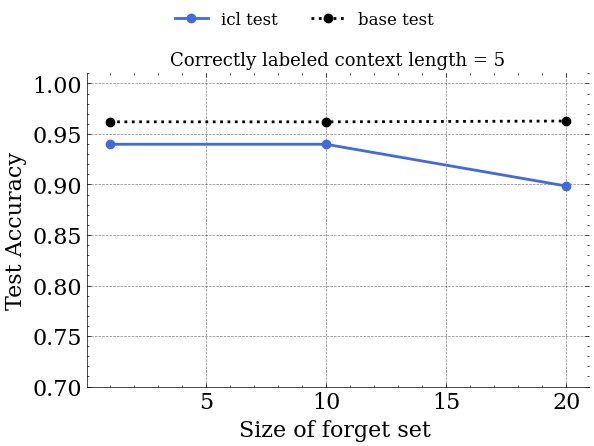

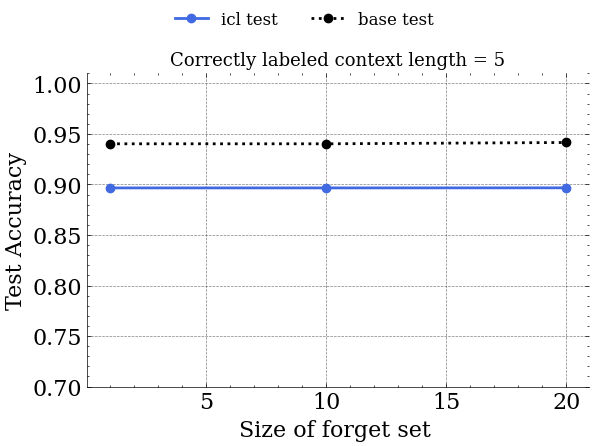

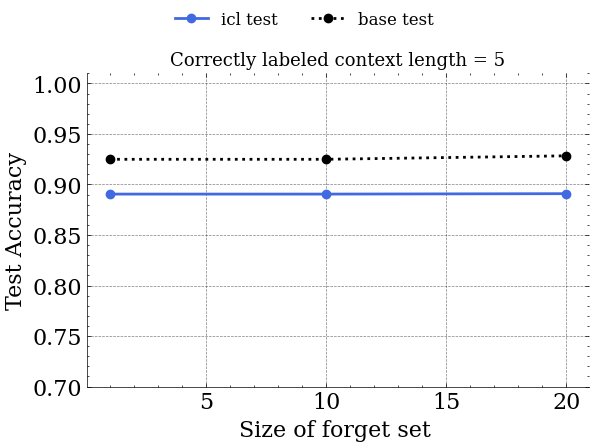

In [12]:
if True:
    model_name = 'OLMo-2-0425-1B'
    mepochs = 3
    datasets = ['amazon_polarity', 'ag_news' , 'sst2']
    # dataset_name = 'amazon_polarity'  # 'sst2', 'amazon_polarity', 'ag_news'
    ubs_list = [1, 10, 20]
    nctxt_list = [6]
    mode = 'icl'

    for dataset_name in datasets:
        
        all_results = {ubs: {'icl': {}, 'base': {}} for ubs in ubs_list}

        for nctxt in nctxt_list:
            for ubs in ubs_list:
                results = get_mean_accuracy(model_name, dataset_name, mode, 'vary', nctxt=nctxt, ubs=ubs, mepochs=mepochs, prefix=prefix)
                all_results[ubs]['icl'][nctxt] = results['icl']
                all_results[ubs]['base'][nctxt] = results['base']


        plt.style.use('matplot.mplstyle')
        fig, axs = plt.subplots(1, len(nctxt_list), figsize=(6 * len(nctxt_list), 4), sharey=True)
        xlims = (0.7, 1.01)

        if len(nctxt_list) == 1:
            axs = [axs]

        for i, nctxt in enumerate(nctxt_list):
            ax = axs[i]
            for method in ['icl', 'base']:
                res_test = [all_results[ubs][method][nctxt]['test'] for ubs in ubs_list]
                res_test[0] = res_test[1]
                linestyle = 'dotted' if method == 'base' else 'solid'
                ax.plot(
                    ubs_list,
                    res_test,
                    label=f'{method} test' if i == 0 else None,
                    marker='o',
                    color='royalblue' if method == 'icl' else 'black',
                    linestyle=linestyle,
                    linewidth=2
                )

            ax.set_title(f'Correctly labeled context length = {nctxt - 1}', fontsize=13)
            ax.set_xlabel('Size of forget set ')
            if i == 0:
                ax.set_ylabel('Test Accuracy')
            ax.set_ylim(xlims)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.grid(True)

        # Shared legend
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 1.05])

        plt.savefig(f'accuracy_results/{model_name}_{dataset_name}_test_accuracy.png', dpi=300)
